In [18]:
import pandas as pd
import numpy as np
from tensorflow import random
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import seaborn as sns
from scikeras.wrappers import KerasClassifier
import pickle


<h1>Data Prepration</h1>

In [19]:
dataset = pd.read_csv('datasets/crop_recommendation.csv')
dataset.sample(10)

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall,Crop
784,27,62,24,28.630055,66.770943,7.353877,62.273735,Blackgram
622,28,45,23,29.650212,80.298683,6.489259,56.762784,MungBean
891,0,67,22,29.821121,69.407321,6.593798,51.564611,Lentil
1779,68,69,52,25.654923,92.745016,6.813383,52.954779,Papaya
1274,16,145,199,26.916248,80.768389,5.953966,69.309272,Grapes
713,55,66,22,30.912195,68.794274,7.747775,66.638306,Blackgram
238,46,76,77,18.235675,19.685385,6.967843,83.748793,ChickPea
671,37,50,23,29.652969,88.485874,6.530471,56.019132,MungBean
2058,89,57,43,26.915150,73.198975,6.998787,177.223305,Jute
1637,6,8,11,24.355909,92.396517,6.600949,119.694658,Orange


In [20]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Nitrogen     2200 non-null   int64  
 1   Phosphorus   2200 non-null   int64  
 2   Potassium    2200 non-null   int64  
 3   Temperature  2200 non-null   float64
 4   Humidity     2200 non-null   float64
 5   pH_Value     2200 non-null   float64
 6   Rainfall     2200 non-null   float64
 7   Crop         2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [21]:
dataset.describe()

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [22]:
dataset.dtypes

Nitrogen         int64
Phosphorus       int64
Potassium        int64
Temperature    float64
Humidity       float64
pH_Value       float64
Rainfall       float64
Crop            object
dtype: object

In [23]:
dataset.isna().sum()

Nitrogen       0
Phosphorus     0
Potassium      0
Temperature    0
Humidity       0
pH_Value       0
Rainfall       0
Crop           0
dtype: int64

In [24]:
# Change the columns into lowercases
df = pd.DataFrame(dataset)
df.columns = df.columns.str.lower()

X = df.iloc[:, :7]
y = df['crop']
print(f'Number of samples in the dataset : {X.shape[0]}')
print(f'Number features for each exmaple : {X.shape[1]}')
print(f'Features : {X.columns}')

print(f'Possible output classes : {y.unique()}')

Number of samples in the dataset : 2200
Number features for each exmaple : 7
Features : Index(['nitrogen', 'phosphorus', 'potassium', 'temperature', 'humidity',
       'ph_value', 'rainfall'],
      dtype='object')
Possible output classes : ['Rice' 'Maize' 'ChickPea' 'KidneyBeans' 'PigeonPeas' 'MothBeans'
 'MungBean' 'Blackgram' 'Lentil' 'Pomegranate' 'Banana' 'Mango' 'Grapes'
 'Watermelon' 'Muskmelon' 'Apple' 'Orange' 'Papaya' 'Coconut' 'Cotton'
 'Jute' 'Coffee']


<h1>Data visualization<h1>

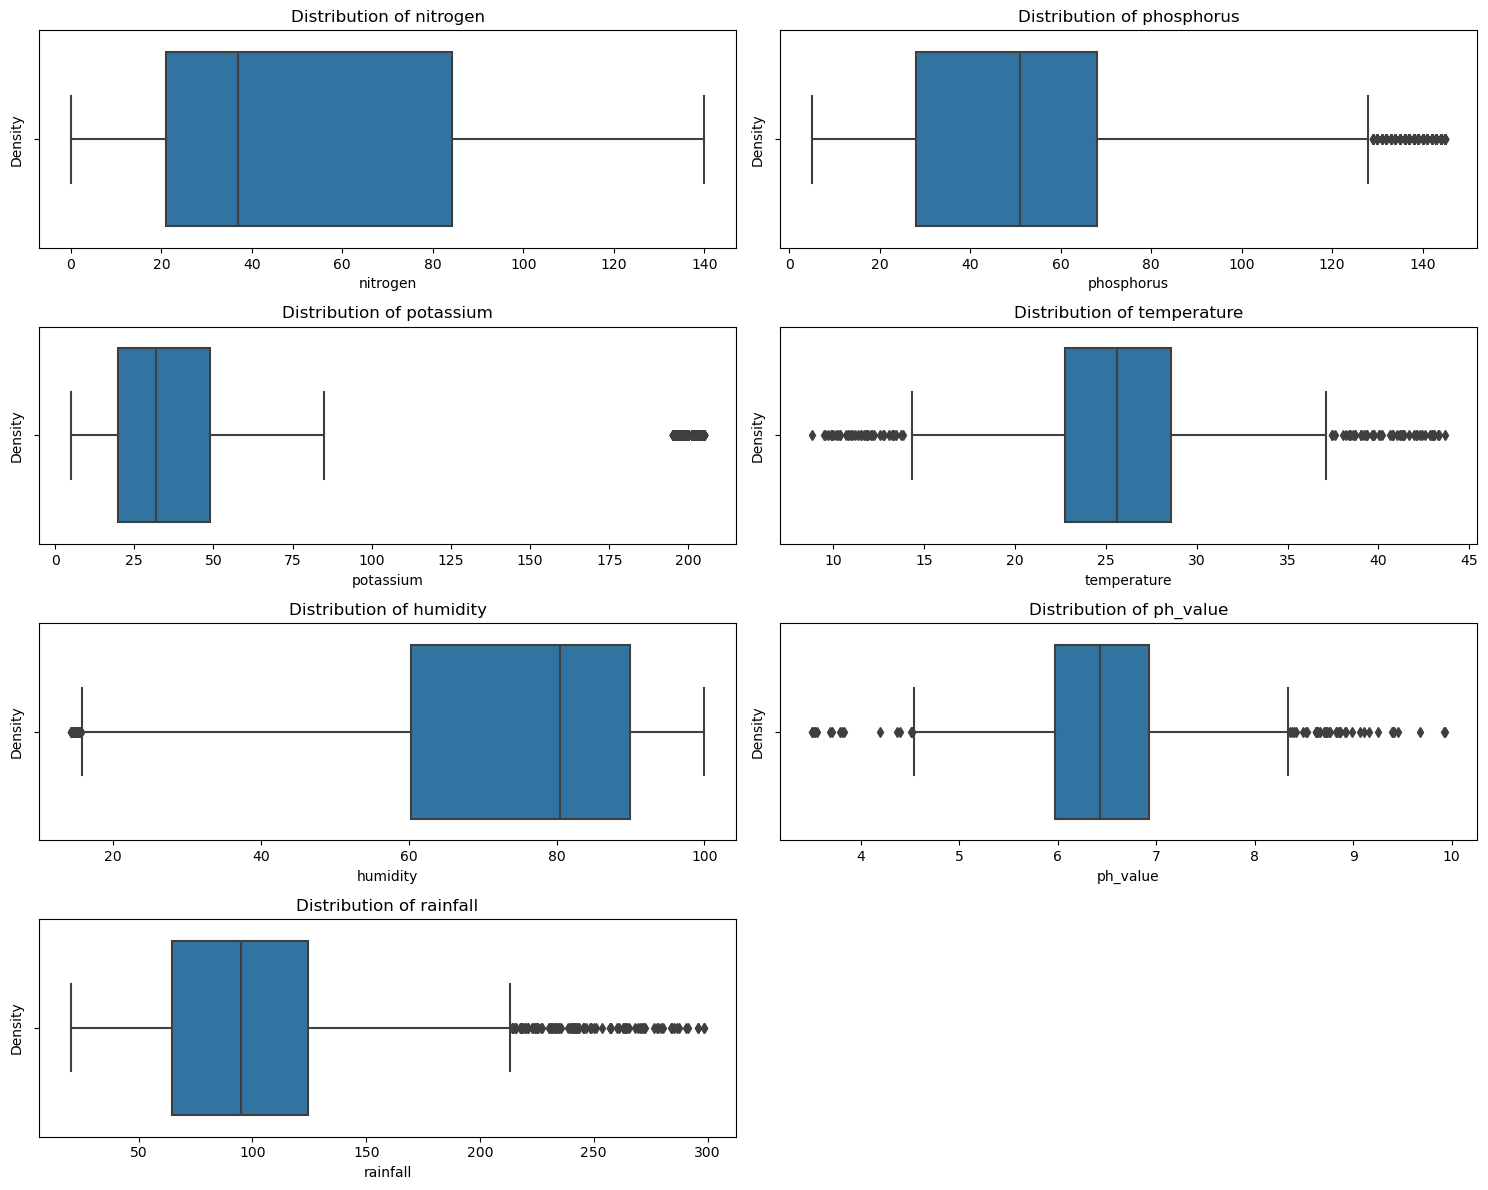

In [25]:
list_columns = [column for column in X.columns if X[column].dtype != 'dtype']

plt.figure(figsize=(15,12))
for i, column in enumerate(list_columns, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(data=df, x=column)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')


plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Nitrogen versus Rainfall')

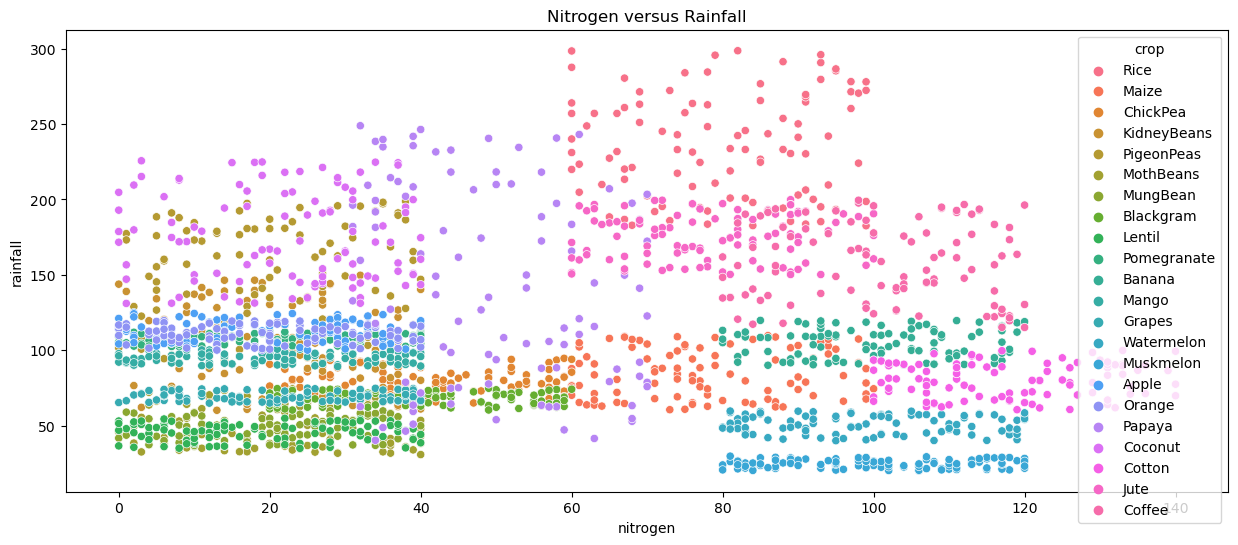

In [26]:
# Explore the individual relationship
plt.figure(figsize=(15,6))
sns.scatterplot(x='nitrogen', y='rainfall', hue='crop', data=df)
plt.title('Nitrogen versus Rainfall')


In [27]:
# Convert the string into numeric value
label_encoder = LabelEncoder()
y_label_encoded = label_encoder.fit_transform(y)



<h1>Building and trainign the model</h1>

In [28]:
# Standardize the X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [29]:
# build a model
def build_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(len(y.unique()), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [30]:
# Wrap using KerasClassifier
classifier = KerasClassifier(build_fn=build_model, epochs=100, batch_size=10, verbose=1, shuffle=False)

# Define the cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross fold
results = cross_val_score(classifier, X_scaled, y_label_encoded, cv=kfold) 

# Clear output
from IPython.display import clear_output
clear_output()




In [31]:
# Print the accuracy result
for i in range(5):
    print(f'Test accuracy result {i+1} : {results[i]}')

print('\n')
print(f'The Final cross-validation test accuracy : {results.mean()}')
print(f'Stand deviation of the final test accuracy : {results.std()}');


Test accuracy result 1 : 0.9772727272727273
Test accuracy result 2 : 0.9795454545454545
Test accuracy result 3 : 0.9818181818181818
Test accuracy result 4 : 0.9795454545454545
Test accuracy result 5 : 0.9886363636363636


The Final cross-validation test accuracy : 0.9813636363636362
Stand deviation of the final test accuracy : 0.003910147848655748


In [32]:
# Train the model
classifier.fit(X_scaled, y_label_encoded)


Epoch 1/100


C:\Users\GIBETIROL\.conda\envs\is2\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\GIBETIROL\.conda\envs\is2\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 657us/step - accuracy: 0.0614 - loss: 3.0556  
Epoch 2/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - accuracy: 0.2135 - loss: 2.5979
Epoch 3/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - accuracy: 0.2931 - loss: 2.0402
Epoch 4/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - accuracy: 0.4110 - loss: 1.5013
Epoch 5/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - accuracy: 0.5069 - loss: 1.1894
Epoch 6/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - accuracy: 0.5856 - loss: 0.9435
Epoch 7/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - accuracy: 0.6809 - loss: 0.7710
Epoch 8/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - accuracy: 0.7269 - loss: 0.6443
Epoch 9/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - accuracy: 0.7633 - loss: 0.5469
Epoch 10/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - accuracy: 0.7867 - loss: 0.4790
Epoch 11/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - accuracy: 0.8161 - loss: 0.4252
Epoch 12/100
220/220 ━━━━━━━━

KerasClassifier(
	model=None
	build_fn=<function build_model at 0x0000022F79259C60>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=10
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=False
	run_eagerly=False
	epochs=100
	class_weight=None
)

In [33]:
N = 4 #Nitrogen
P = 19 #Phosphorus
K = 43  # Potassium
T = 18.07132963  # Temperature
H = 93.14554876  # Humidity
pH = 5.779427402 # PH value
R = 106.3602023# Rainfall

X_new = np.array([[N, P, K, T, H, pH, R]])

y_pred = classifier.predict(X_new)
print(label_encoder.inverse_transform(y_pred))

In [34]:
# Save the model and label encoder to pickle files


Model and encoders saved successfully!
